In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from scipy.special import comb

In [17]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

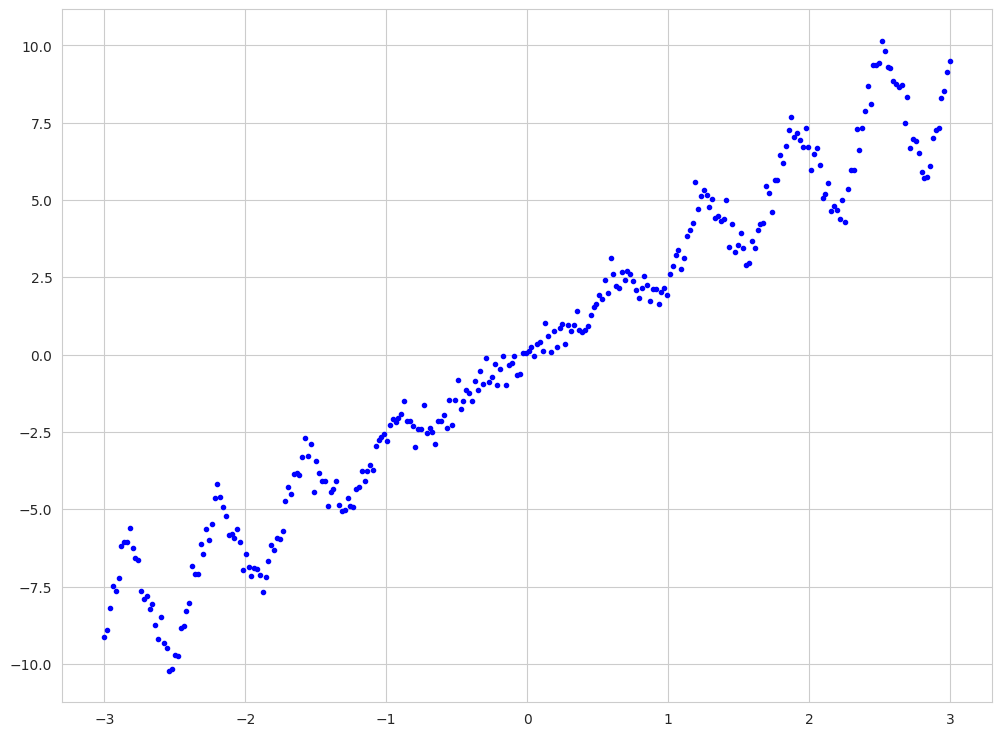

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, depth, ax, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)


    ax.set_xlabel("$x_1$", fontsize=18)
    ax.set_title(f'depth={depth}', fontsize=21)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=18, rotation=0)

    ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

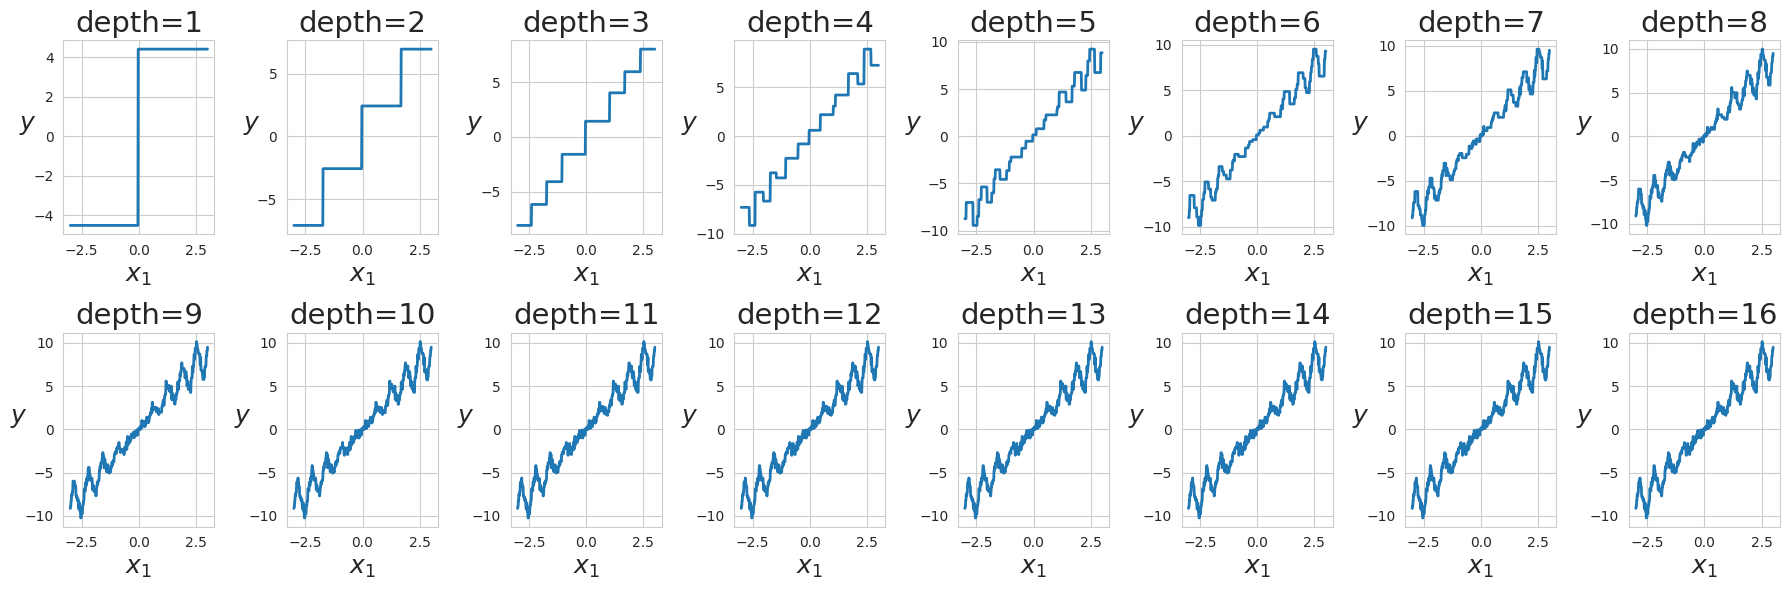

In [5]:
fig, axs = plt.subplots(2, 8, figsize=(18, 6))
axs = axs.flatten()

for depth, ax in enumerate(axs, 1):
    tree_regressor = DecisionTreeRegressor(max_depth=depth)
    tree_regressor.fit(X, y)
    plot_regression_predictions(tree_regressor, X, y, depth, ax)

plt.tight_layout()
plt.show()


> На мой взгляд `depth=6` выглядит наиболее сбалансировано.

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


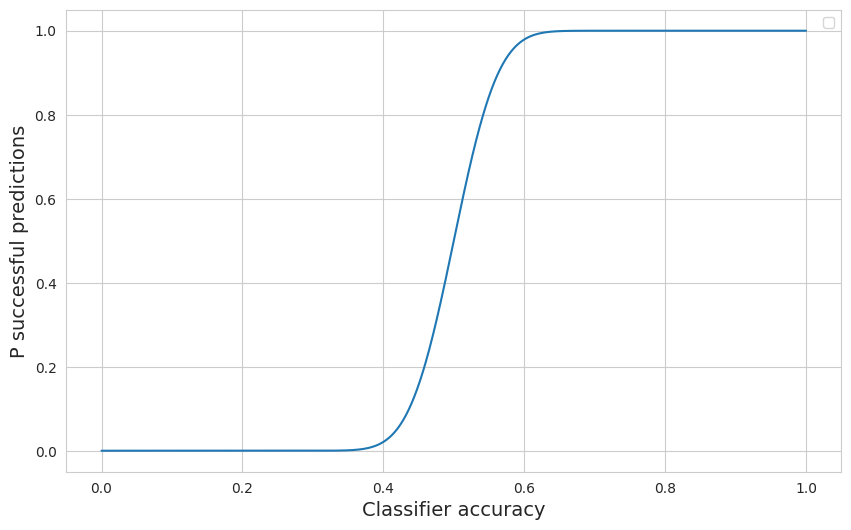

In [6]:
def probability_correct_classification(p):
    mu = sum(comb(101, i) * (p ** i) * ((1 - p) ** (101 - i)) for i in range(51, 102))
    return mu


p = np.linspace(0, 1, 1000)

probabilities = [probability_correct_classification(p) for p in p]


plt.figure(figsize=(10, 6))
plt.plot(p, probabilities)
plt.xlabel('Classifier accuracy', fontsize=14)
plt.ylabel('P successful predictions', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


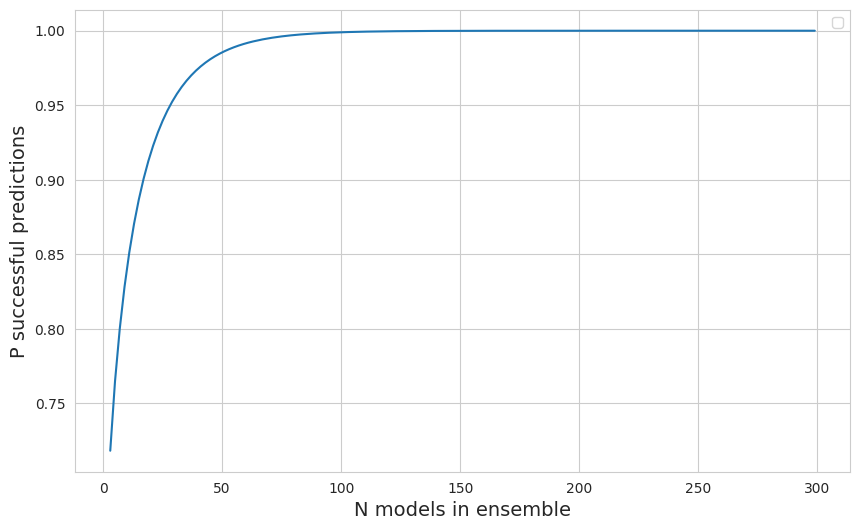

In [7]:
def probability_correct_classification(n_models):
    mu = sum(comb(n_models, i) * (0.65 ** i) * ((1 - 0.65) ** (n_models - i)) for i in range((n_models + 1) // 2, n_models + 1))
    return mu


n_models = [n for n in range(3, 300, 2)]

probabilities = [probability_correct_classification(n_models) for n_models in n_models]

plt.figure(figsize=(10, 6))
plt.plot(n_models, probabilities)
plt.xlabel('N models in ensemble', fontsize=14)
plt.ylabel('P successful predictions', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

Опишите ваши наблюдения:

* Глядя на первый график, можно заметить, что даже при низком значении `p` для каждой модели (например, при `p=0.6`), вероятность успеха ансамбля гораздо выше. Получается, видна потенциальная польза от применения ансамблей.

* На втором графике вероятность успешных предсказаний ансамбля стремительно растет при увеличении числа моделей с 3 до 100. Далее вероятность успеха остается близка к 1. Несмотря на это вероятность успеха ансамбля даже из 25 моделей достаточно высокая, т.е. видно, что и небольшие ансамбли могут оказываться действенными. Однако, похоже, что для создания успешного ансамбля необходимо не меннее 50 моделей. 

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators - 1):
            random.seed(self.random_state + i)
            features = np.random.choice(X.shape[1], 
                                self.max_features,
                                replace=False)
            self.feat_ids_by_tree.append(features)

            bootstrap_idx = np.random.choice(X.shape[0], size=X.shape[0],
                                             replace=True)
            
            X_bagging = X[bootstrap_idx][:,features]
            y_bagging = y[bootstrap_idx]

            tree_classifier = DecisionTreeClassifier(max_depth=self.max_depth, 
                        max_features=self.max_features,
                        random_state=self.random_state)
            
            tree_classifier.fit(X_bagging, y_bagging)
            self.trees.append(tree_classifier)

    def predict_proba(self, X):
        probabilities = []

        for idx, tree in enumerate(self.trees):
            probabilities.append(tree.predict_proba(X[:,self.feat_ids_by_tree[idx]]))
            
        return(np.mean(probabilities, axis=0))
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, ax, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    ax.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        ax.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    ax.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    ax.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    ax.axis(axes)
    ax.set_xlabel(r"$x_1$", fontsize=18)
    ax.set_ylabel(r"$x_2$", fontsize=18, rotation=0)

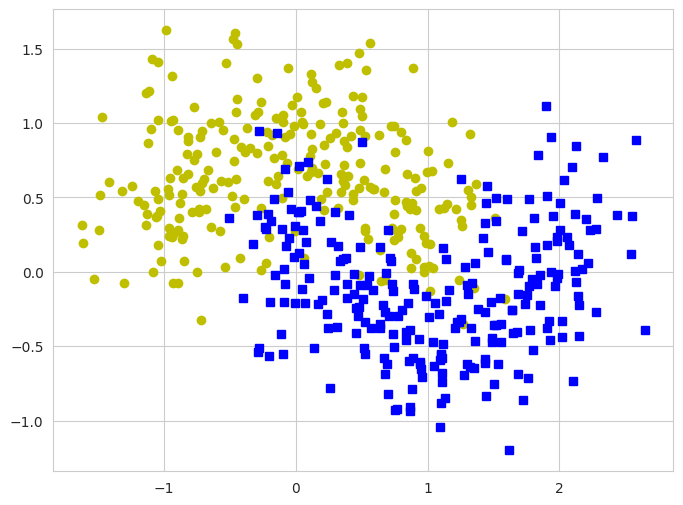

In [10]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

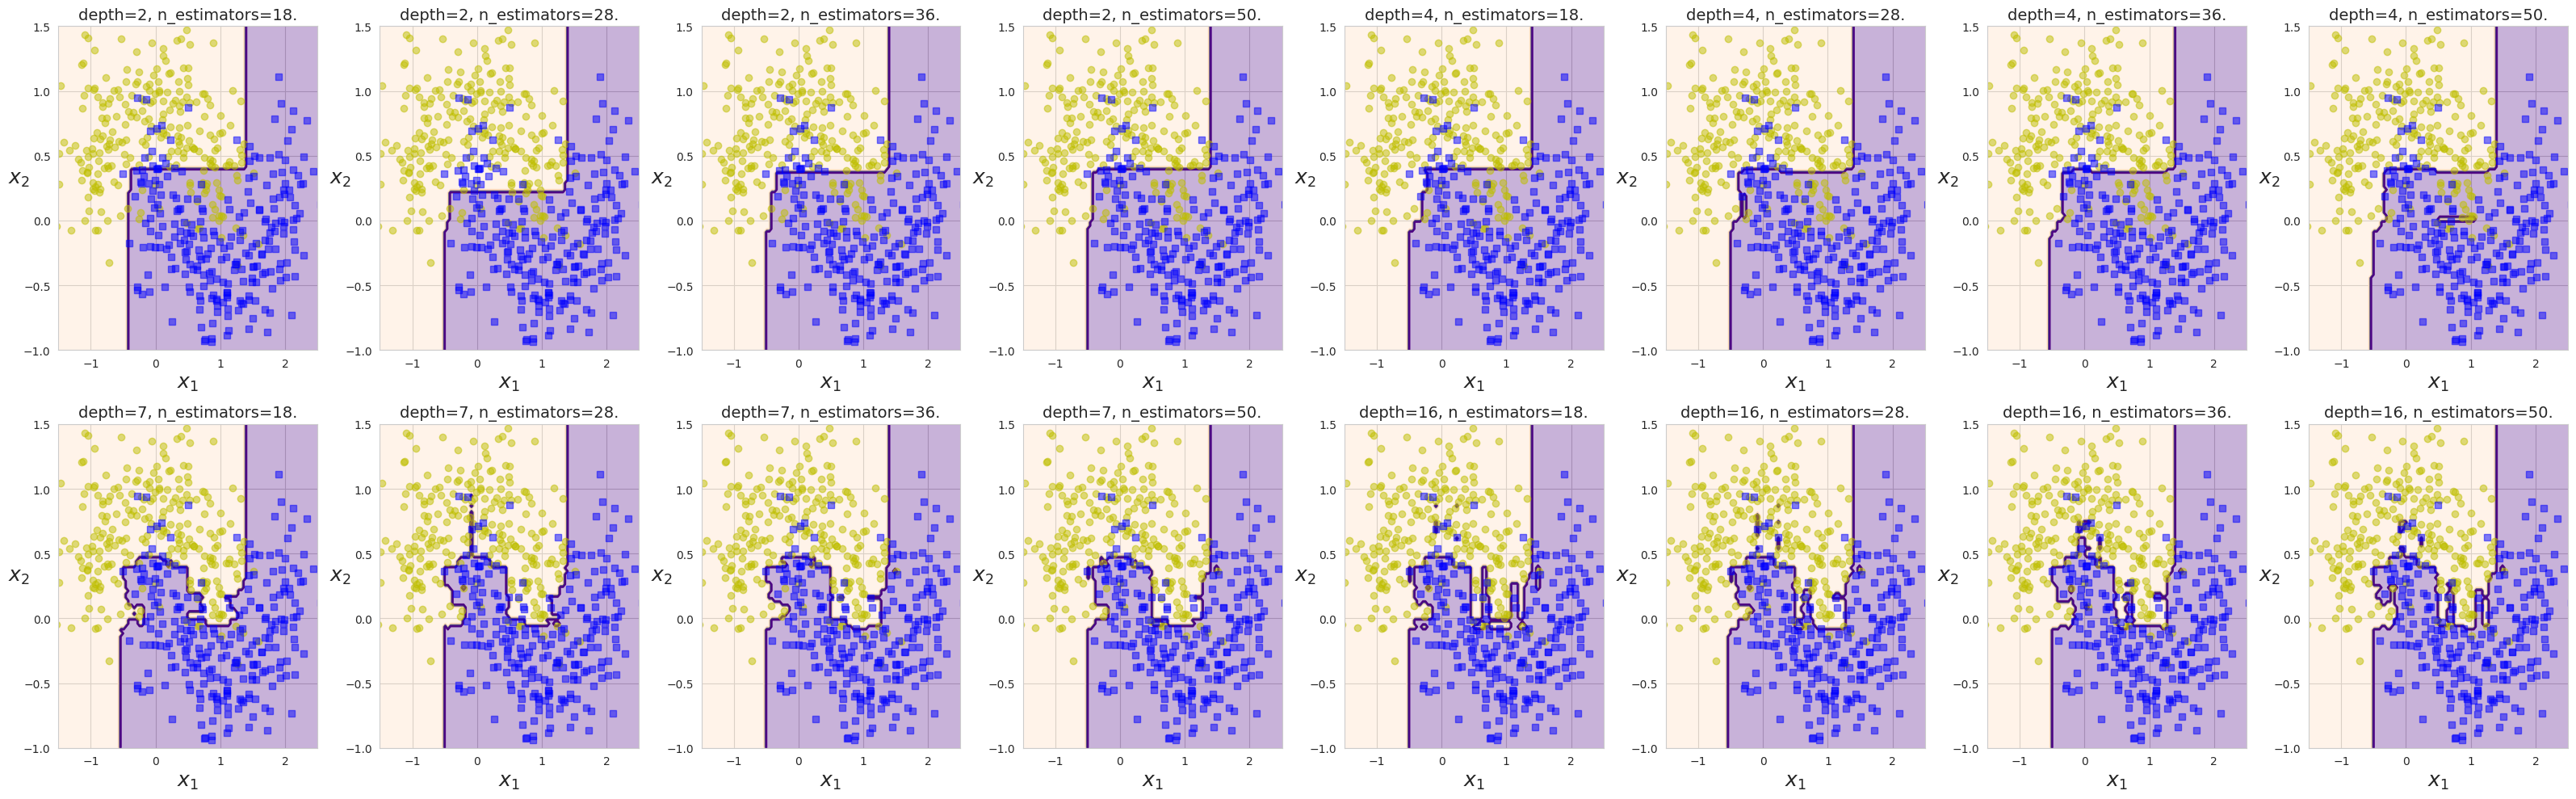

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

n_estimators = [18, 28, 36, 50]
max_depth = [2, 4, 7, 16]

fig, axs = plt.subplots(2, 8, figsize=(32, 10))
axs = axs.flatten()

idx = 0
for depth in max_depth:
    for n_estimator in n_estimators:
        tree_cl = RandomForestClassifierCustom(n_estimators=n_estimator, max_depth=depth, max_features=2, random_state=SEED)
        tree_cl.fit(X_train, y_train)
        plot_decision_boundary(tree_cl, X, y, axs[idx])
        axs[idx].set_title(f"depth={depth}, n_estimators={n_estimator}.", fontsize=14)
        idx += 1

plt.tight_layout()
plt.show()

> Визуально граница кажется наиболее правильной при `max_depth=7` и `n_estimators=50`. Посмотрим на значения accuracy.

In [12]:
accuracy_df = pd.DataFrame(columns=['max_depth', 'n_estimators', 'accuracy'])


for depth in max_depth:
    for n_estimator in n_estimators:
        tree_cl = RandomForestClassifierCustom(n_estimators=n_estimator, max_depth=depth, max_features=2, random_state=SEED)
        accuracy = cross_val_score(tree_cl, X_train, y_train, cv=5, scoring='accuracy').mean()
        accuracy_df.loc[len(accuracy_df)] = [depth, n_estimator, accuracy]

accuracy_df.sort_values(by='accuracy', ascending=False)

,max_depth,n_estimators,accuracy
11,7.0,50.0,0.917333
15,16.0,50.0,0.912000
8,7.0,18.0,0.909333
10,7.0,36.0,0.906667
9,7.0,28.0,0.901333
14,16.0,36.0,0.898667
13,16.0,28.0,0.896000
12,16.0,18.0,0.893333
0,2.0,18.0,0.882667
7,4.0,50.0,0.872000


> Кажется, предположение подтверждается

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [13]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for est1, est2 in combinations(ensemble.estimators_, 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [14]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

Text(0, 0.5, 'models correlation')

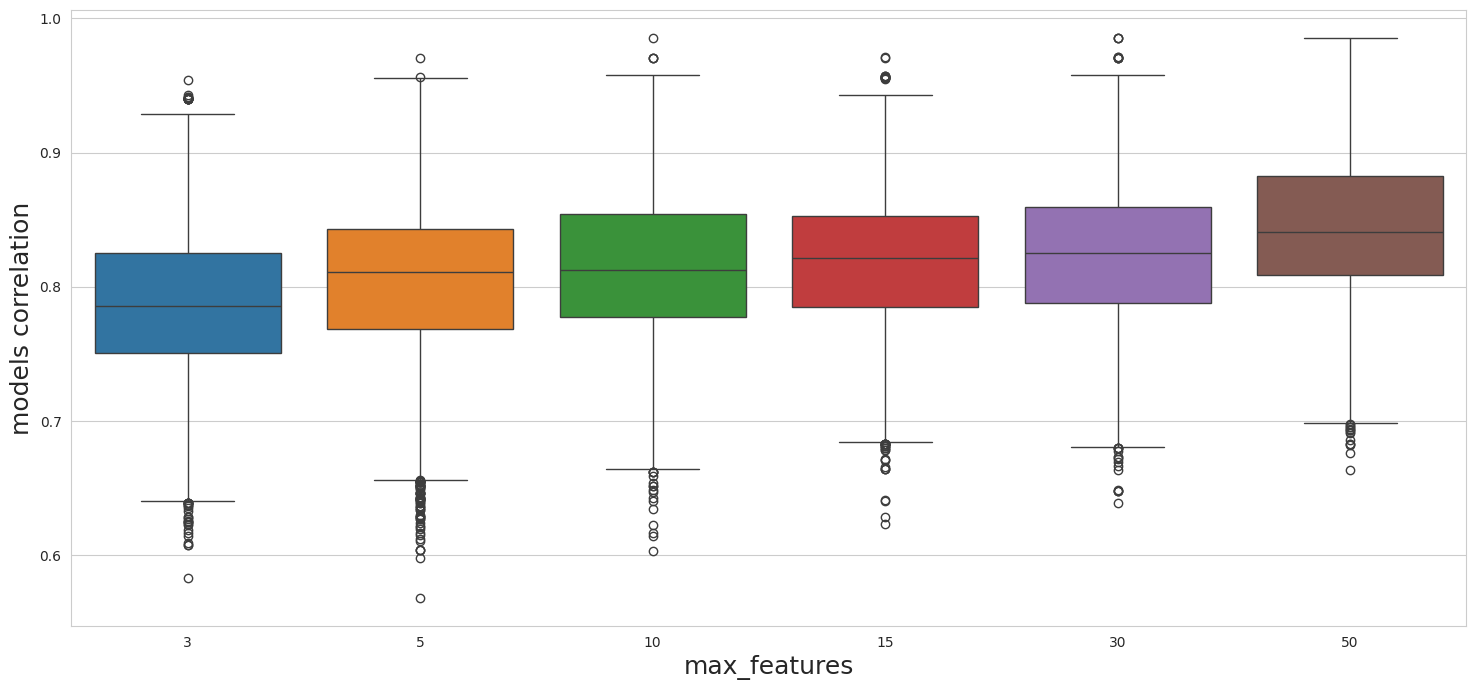

In [15]:
# Влияние параметра max_features на корреляцию моделей 

max_features = [3,5,10,15,30,50]
corrs_df = pd.DataFrame(columns=max_features)

for max_feature in max_features:
    tree_cl = RandomForestClassifier(max_features=max_feature)
    tree_cl.fit(X_train, y_train)
    corrs_df[max_feature] = (base_model_pair_correlation(tree_cl, X_test))

plt.figure(figsize=(18,8))
sns.boxplot(data=corrs_df)
plt.xlabel("max_features", size=18)
plt.ylabel("models correlation", size=18)

Опишите ваши наблюдения:

* Корреляция достаточно высокая для всех наборов признаков
* Кажется, что корреляция увеличивается с увеличением количества признаков, но не стремительно. Возможно, дальше она будет постоянно находиться около значения 0.8

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [114]:
# !gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [115]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [124]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, criterion='entropy')
etc = ExtraTreesClassifier(random_state=SEED, n_estimators= 100)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, gamma='auto', random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED, n_estimators=500)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

> Оценим качество моделей с помощью кросс-валидации

In [85]:
%%capture

f1_df = pd.DataFrame(columns=['classifier', 'f1'])

trained_models = {}

for model in base_models:
    classifier_name = model[0]
    classifier = model[1]
    classifier.fit(X_train, y_train)
    trained_models[classifier_name] = classifier
    f1 = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1').mean()
    f1_df.loc[len(f1_df)] = [classifier_name, f1]

votings = ['hard', 'soft']

for voting in votings:
    voting_cl = VotingClassifier(estimators=base_models, voting=voting)
    voting_cl.fit(X_train, y_train)
    trained_models[f'votcl_{voting}'] = voting_cl
    f1 = cross_val_score(voting_cl, X_train, y_train, cv=5, scoring='f1').mean()
    f1_df.loc[len(f1_df)] = [f'votcl_{voting}', f1]

In [86]:
f1_df.sort_values(by='f1', ascending=False)

,classifier,f1
11,LR,0.858234
4,SVC_LIN,0.857082
14,votcl_soft,0.854079
1,RF,0.843815
13,votcl_hard,0.842785
6,CAT,0.836667
2,ETC,0.817318
12,NB,0.812630
9,XGB,0.809696
7,LGBM,0.809669


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [87]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [88]:
%%capture
corrs = base_model_pair_correlation_for_voting_clf(trained_models['votcl_hard'], X)

> Посмотрим, какие модели сильно коррелируют друг с другом ( > 0.95)

In [89]:
for idx in range(len(corrs)):
    if corrs[idx][2] > 0.95:
        print(corrs[idx][0].__class__.__name__, corrs[idx][1].__class__.__name__)

RandomForestClassifier ExtraTreesClassifier
RandomForestClassifier CatBoostClassifier
RandomForestClassifier LGBMClassifier
RandomForestClassifier XGBClassifier
RandomForestClassifier XGBRFClassifier
ExtraTreesClassifier CatBoostClassifier
ExtraTreesClassifier LGBMClassifier
ExtraTreesClassifier XGBClassifier
SVC LogisticRegression
CatBoostClassifier LGBMClassifier
CatBoostClassifier XGBClassifier
CatBoostClassifier XGBRFClassifier
LGBMClassifier XGBClassifier


> Попробуеи улучшить результат за счет удаления скоррелированных моделей

In [147]:
%%capture
votings = ['hard', 'soft']
to_delete = [("ETC", etc), ("CAT", cat), ("LGBM", lgbm), ("LGBM_RF", lgbm_rf)]
new_models = base_models.copy()

for model in to_delete:
    new_models.remove(model)

f1_dict = {}

for voting in votings:
    voting_cl = VotingClassifier(estimators=new_models, voting=voting)
    voting_cl.fit(X_train, y_train)
    f1 = cross_val_score(voting_cl, X_train, y_train, cv=5, scoring='f1').mean()
    f1_dict[voting] = f1

In [148]:
for voting_type in f1_dict:
    print(f"f1 for voting {voting_type}: {f1_dict[voting_type]})")

f1 for voting hard: 0.8542019842862878)
f1 for voting soft: 0.8637168342514311)


In [28]:
%%capture
votings = ['hard', 'soft']
to_delete = [("ETC", etc), ("CAT", cat), ("LGBM", lgbm), ("XGB", xgb)]
new_models = base_models.copy()

for model in to_delete:
    new_models.remove(model)

f1_dict = {}

for voting in votings:
    voting_cl = VotingClassifier(estimators=new_models, voting=voting)
    voting_cl.fit(X_train, y_train)
    f1 = cross_val_score(voting_cl, X_train, y_train, cv=5, scoring='f1').mean()
    f1_dict[voting] = f1

In [125]:
for voting_type in f1_dict:
    print(f"f1 for voting {voting_type}: {f1_dict[voting_type]})")

f1 for voting hard: 0.8530115080958117)
f1 for voting soft: 0.8623652495924101)


> Ничего не получается :( Попробую предобработать данные.

In [149]:
heart_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [150]:
heart_dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [151]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [152]:
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    remainder='passthrough'
)

In [153]:
def Standard_Scaler(df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [154]:
X = heart_dataset.drop("target", axis=1)

X = Standard_Scaler(X, numerical_cols)
X = one_hot_encoder.fit_transform(X)

y = heart_dataset["target"]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [155]:
%%capture
votings = ['hard', 'soft']
to_delete = [("ETC", etc), ("CAT", cat), ("LGBM", lgbm), ("LGBM_RF", lgbm_rf)]
new_models = base_models.copy()

for model in to_delete:
    new_models.remove(model)

f1_dict = {}

for voting in votings:
    voting_cl = VotingClassifier(estimators=new_models, voting=voting)
    voting_cl.fit(X_train, y_train)
    f1 = cross_val_score(voting_cl, X_train, y_train, cv=5, scoring='f1').mean()
    f1_dict[voting] = f1

In [156]:
for voting_type in f1_dict:
    print(f"f1 for voting {voting_type}: {f1_dict[voting_type]})")


f1 for voting hard: 0.8259509402969499)
f1 for voting soft: 0.8282477289117859)


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

#### EDA

In [24]:
data = pd.read_csv("churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [25]:
data.shape

(3333, 21)

In [26]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [28]:
data = data.drop(columns=['Phone'])

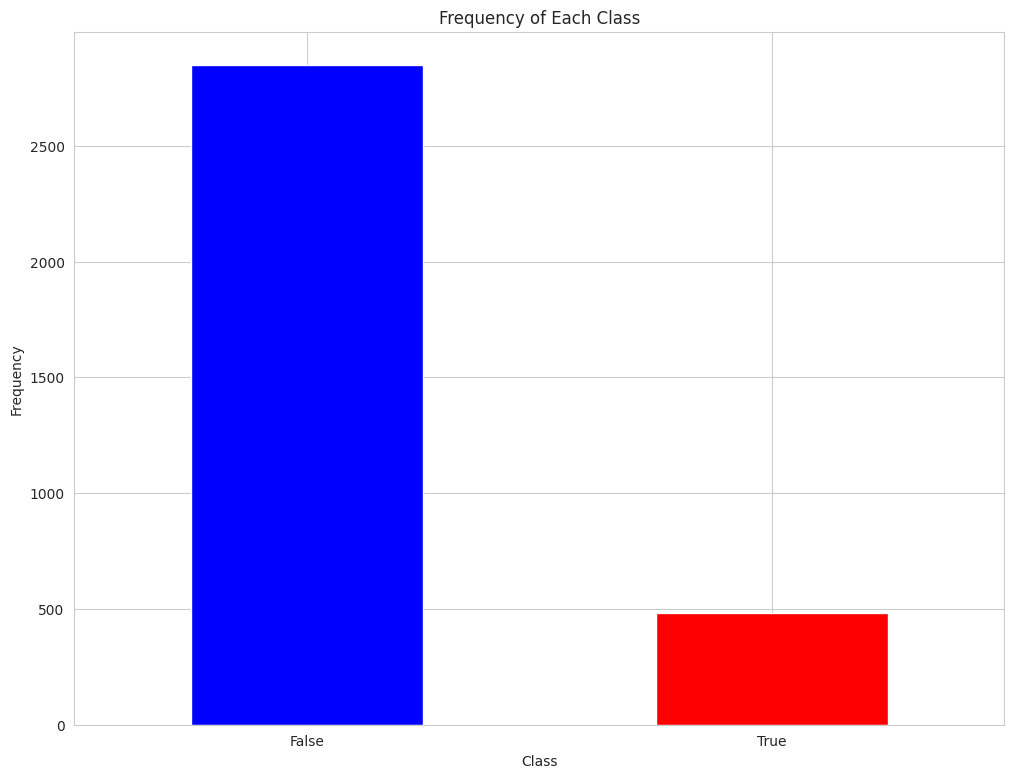

In [29]:
class_counts = data['Churn?'].value_counts()
class_counts.plot(kind='bar', color=['blue', 'red'])

plt.title('Frequency of Each Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['False', 'True'], rotation=0) 
plt.show()

#### Label encoding and data split 

In [30]:
target_dict = {
    "False.": 0,
    "True.": 1
}

data.replace({"Churn?": target_dict}, inplace=True)

X = data.drop('Churn?', axis=1)
y = data['Churn?']

In [31]:
categorical_idx = [0,2,3,4]

one_hot_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_idx),
    remainder='passthrough'
)
X_transformed = one_hot_encoder.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=SEED)

#### Бустинг xgboost.XGBClassifier

In [32]:
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 = {f1}')

f1 = 0.8


In [33]:
cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1").mean()

0.8281036522499768

> Попробуем улучшить. Разделим множество параметров для бустинга на две области и поищем лучшие с помощью `hyperopt`

In [34]:
space_1={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'n_estimators': 180,
        'eta' : hp.uniform('eta', 0,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,12),
        'subsample': hp.uniform('subsample', 0,1),
        'tree_method': hp.choice('tree_method', ('auto', 'exact', 'approx', 'hist')),
        }

In [35]:
def objective_1(space):

    xgb = xgboost.XGBClassifier(
    random_state=SEED,
    eta = space['eta'],
    scale_pos_weight = space['scale_pos_weight'],
    n_estimators=space['n_estimators'],
    max_depth=int(space['max_depth']),
    gamma=space['gamma'],
    subsample=space['subsample'],
    tree_method=space['tree_method']
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    xgb.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric='error',
        early_stopping_rounds=50,
        verbose=False,
    )

    # f1 = cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1").mean()
    y_pred = xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return {'loss': -f1, 'status': STATUS_OK}

In [36]:
trials = Trials()

best_hyperparams_xbg_1 = fmin(fn = objective_1,
                        space = space_1,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

100%|██████████| 3000/3000 [17:05<00:00,  2.93trial/s, best loss: -0.8623853211009175]


In [37]:
print("Some of the best hyperparameters are : ","\n")
print(best_hyperparams_xbg_1)

Some of the best hyperparameters are :  

{'eta': 0.2369420091025511, 'gamma': 2.2468686364124517, 'max_depth': 11.0, 'scale_pos_weight': 1.5185618420980989, 'subsample': 0.7780025107454773, 'tree_method': 1}


In [38]:
space_2={'colsample_bytree': hp.uniform('colsample_bytree', 0,1),
        'min_child_weight': hp.uniform ('min_child_weight',0,12),
        'min_split_loss': hp.uniform ('min_split_loss',1,20),
        'reg_alpha' : hp.uniform('reg_alpha',1,100),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        }

In [39]:
def objective_2(space):
    xgb = xgboost.XGBClassifier(
    random_state=SEED,
    colsample_bytree=space['colsample_bytree'],
    min_child_weight=int(space['min_child_weight']),
    min_split_loss=space['min_split_loss'],
    reg_alpha=int(space['reg_alpha']),
    reg_lambda=space['reg_lambda']
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    xgb.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric='error',
        early_stopping_rounds=50,
        verbose=False,
    )

    # f1 = cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1").mean()
    y_pred = xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    
    return {'loss': -f1, 'status': STATUS_OK}

In [40]:
trials = Trials()

best_hyperparams_xbg_2 = fmin(fn = objective_2,
                        space = space_2,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

100%|██████████| 3000/3000 [03:37<00:00, 13.81trial/s, best loss: -0.8436018957345972]


In [41]:
print("Other of the best hyperparameters are : ","\n")
print(best_hyperparams_xbg_2)

Other of the best hyperparameters are :  

{'colsample_bytree': 0.8720897349109329, 'min_child_weight': 3.5046076106735002, 'min_split_loss': 1.673929936306303, 'reg_alpha': 1.0254761834986674, 'reg_lambda': 0.3044714477880615}


> Возьмемем первый из улучшенных наборов признаков, в нем как раз оптимизировались основные параметры типа `max_depth` и `scale_pos_weight`. Сначала пробовала использовать сразу все улучшенные параметры, но получалось хуже.

In [57]:
xgb_new = xgboost.XGBClassifier(eta = best_hyperparams_xbg_1['eta'],
                                scale_pos_weight = best_hyperparams_xbg_1['scale_pos_weight'],
                                n_estimators=180,
                                max_depth=int(best_hyperparams_xbg_1['max_depth']),
                                gamma=best_hyperparams_xbg_1['gamma'],
                                subsample=best_hyperparams_xbg_1['subsample'],
                                tree_method='exact',
                                random_state=SEED
                                )
evaluation = [( X_train, y_train), ( X_test, y_test)]

xgb_new.fit(
    X_train,
    y_train,
    eval_set=evaluation,
    eval_metric='error',
    verbose=False,
)

y_pred = xgb_new.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 = {f1}')

f1 = 0.8584474885844748


In [58]:
cross_val_score(xgb_new, X_train, y_train, cv=5, scoring="f1").mean()

0.8250397313469311

> Что ж, после долгих попыток f1 на тесте стал получше

#### Случайный лес xgboost.XGBRFClassifier

In [44]:
xgbrf = xgboost.XGBRFClassifier(random_state=SEED)
xgbrf.fit(X_train, y_train)
y_pred = xgbrf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 = {f1}')

f1 = 0.7757009345794392


In [45]:
cross_val_score(xgbrf, X_train, y_train, cv=5, scoring="f1").mean()

0.8027543601817266

> Попробуем улучшить похожим образом

In [46]:
space_1={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'n_estimators': 180,
        'eta' : hp.uniform('eta', 0,1),
        'scale_pos_weight' : hp.uniform('scale_pos_weight', 0,12),
        'subsample': hp.uniform('subsample', 0,1),
        'colsample_bynode': hp.uniform('colsample_bynode', 0,1)
        }

In [47]:
def objective_1(space_1):
    xgb = xgboost.XGBRFClassifier(
    random_state=SEED,
    colsample_bynode = space_1['colsample_bynode'],
    eta = space_1['eta'],
    scale_pos_weight = space_1['scale_pos_weight'],
    n_estimators=space_1['n_estimators'],
    max_depth=int(space_1['max_depth']),
    gamma=space_1['gamma'],
    subsample=space_1['subsample'],
    tree_method='exact'
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    xgb.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric='error',
        verbose=False,
    )

    # f1 = cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1").mean()
    y_pred = xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return {'loss': -f1, 'status': STATUS_OK}

In [48]:
trials = Trials()

best_hyperparams_rf_1 = fmin(fn = objective_1,
                        space = space_1,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)

100%|██████████| 500/500 [05:14<00:00,  1.59trial/s, best loss: -0.8416289592760181]


In [49]:
print("Some of the best hyperparameters are : ","\n")
print(best_hyperparams_rf_1)

Some of the best hyperparameters are :  

{'colsample_bynode': 0.11363016101388015, 'eta': 0.6883862553504112, 'gamma': 4.376817058681474, 'max_depth': 11.0, 'scale_pos_weight': 3.76487417560703, 'subsample': 0.7829509643286889}


In [50]:
space_2={'min_child_weight': hp.uniform ('min_child_weight',0,12),
         'min_split_loss': hp.uniform ('min_split_loss',1,20),
         'reg_alpha' : hp.uniform('reg_alpha',1,100),
         'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        }

In [51]:
def objective_2(space_2):
    
    xgb = xgboost.XGBRFClassifier(
    random_state=SEED,
    min_child_weight=int(space_2['min_child_weight']),
    min_split_loss=space_2['min_split_loss'],
    reg_alpha=int(space_2['reg_alpha']),
    reg_lambda=space_2['reg_lambda'],
    tree_method='exact'
    )

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    xgb.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric='error',
        verbose=False,
    )

    # f1 = cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1").mean()
    y_pred = xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return {'loss': -f1, 'status': STATUS_OK}

In [52]:
trials = Trials()

best_hyperparams_rf_2 = fmin(fn = objective_2,
                        space = space_2,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)

100%|██████████| 500/500 [01:40<00:00,  4.97trial/s, best loss: -0.7714285714285715]


In [53]:
print("Other of the best hyperparameters are : ","\n")
print(best_hyperparams_rf_2)

Other of the best hyperparameters are :  

{'min_child_weight': 0.8601813575811083, 'min_split_loss': 1.6136123449568303, 'reg_alpha': 2.4095354491267953, 'reg_lambda': 0.22358387148666936}


In [59]:
xgbrf_new = xgboost.XGBRFClassifier(eta = best_hyperparams_rf_1['eta'],
                                scale_pos_weight = best_hyperparams_rf_1['scale_pos_weight'],
                                n_estimators=180,
                                max_depth=int(best_hyperparams_rf_1['max_depth']),
                                gamma=best_hyperparams_rf_1['gamma'],
                                subsample=best_hyperparams_rf_1['subsample'],
                                colsample_bynode=best_hyperparams_rf_1['colsample_bynode'],
                                tree_method='exact'
                                )

evaluation = [( X_train, y_train), ( X_test, y_test)]

xgbrf_new.fit(
    X_train,
    y_train,
    eval_set=evaluation,
    eval_metric='error',
    verbose=False,
)

y_pred = xgbrf_new.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'f1 = {f1}')

f1 = 0.8108108108108109


In [60]:
cross_val_score(xgbrf_new, X_train, y_train, cv=5, scoring="f1").mean()

0.7990283103360158

> Снова улучшенный результат на тесте!

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**